# Summary of Findings


### Introduction
<span style="color:Red">**The Prediction Question**</span>
> The classification prediction we are trying to figure out is if a company will either spend above or below the average amount of money spent on ads throughout the whole dataset. We decided to evaluate our model based on accuracy. This is because in our question, the true positives and true negatives are more crucial than the false positives and false negatives. Furthermore, our model would classify false positives and negatives as a “wrong” prediction, lowering our accuracy score, so in our case false positives and false negatives are the same, resulting in a symmetrical dataset. We decided to go with accuracy to get a good perspective on how accurate our model would be on our testing data. We used a K-Neighbors classifier to create our classification model.

<span style="color:Red">**Choice of Target Variable & Evaluation Metric**</span>
> As our target variable we chose ‘Spend’, whether it would be spend above the average or below the average. For both of our models we chose to do accuracy, so from the baseline to the final our goal was to increase the accuracy. 

<span style="color:Red">**Basic Cleaning**</span>
> We first imported the 2018 and 2019 datasets from our raw csv files, and read them into dataframes. We then concatenated the two dataframes together into one master dataframe with all of the information from 2018 and 2019. We cleaned the StartDate and EndDate columns by converting them into DateTime timestamp objects to make it more accessible and malleable. 
> For the 'Gender' column we filled the nulls with 'BOTH' and filled all the 'MALE'/'FEMALE' rows with 'SINGLE' to show that they were geared to only a single gender. For the 'CountryCode' column we combined all countries that weren't 'united states' into a single category 'other', as the majority of the ads came from the U.S. The 'Spend' column is in different currencies, so we convert them all to USD using the appropriate conversion rates. In the 'Spend' column we decided to make it 0/1 to show whether or not the company spent over the average. With the 'StartDate' and 'EndDate' we decided to get the length the ad was running for.

### Baseline Model
> To create our baseline model, we created and used 3 features. We used a one hot encoded gender and country column, as well as an ordinally encoded organization name column. All of our features are nominally encoded, as they are either ordinally encoded or one-hot encoded. We trained our model on these three features, then calculated the accuracy of our prediction. We did this by seeing how many times the prediction predicted correctly on the testing data. We then ran a prediction 1000 times to find the mean accuracy, which was around 0.843. We considered this to be an alright baseline model but also felt that there could be room for improvement. We also felt that using naturally numerical numbers would yield a good improvement, which we tried in our final model.This showed that our model was accurate on average 84.3% of the time, which was pretty good for our baseline. 

### Final Model
> After playing around with different features, we decided to completely change our final model. In our final model, we trained our pipeline around 3 different features: the number of Impressions the ad had, the length of the ad, and the number of impressions per hour the ad had. We felt that these features would greatly improve our model, because generally the number of impressions an ad has can be related to the amount spent. We figured that the more an organization spent on an ad, the more people they would reach. We also figured that a longer ad would cost more money and more likely to be above the average spent. We calculated the length of the ad by first subtracting the end and start time, then converting the days to hours. We calculated the impressions per hour an ad had by dividing the impressions by the total hours the ad had. We decided to use these three features because we tested the features individually and found that they individually had better accuracies than the previous features. After training our model, we calculated the accuracy of it by doing the same thing as the baseline model: seeing how many predictions our model got correct. After running it 1000 times and taking the average accuracy, our model had 0.948 accuracy on average, which is a 0.105 increase in accuracy from our baseline, which we were very satisfied with. This meant that our model is now 94.8% accurate on average. 

### Fairness Evaluation
> In our fairness evaluation, we decided to test to see if the precision of our model would be better or worse on 2 subsets of the original dataset: short ads and long ads. The reason we chose to use precision score was to see whether having a short or long ad influenced the model in predicting that a company with below average spend was actually spending above average spend. To do this, we calculated the observed difference in precision between short ads and long ads, which was a difference of 0.004777839618733903. To see if our model is biased towards either short ads or long ads, we performed a permutation test with a significance level of 0.05. Our null hypothesis is that our model is fair and the precision for our two subsets of data are roughly the same. Our alternative hypothesis is that our model is unfair, the precision of the long ad subset is higher than the short ad subset. After performing our permutation test 1000 times, we got a p-value of 0.798, which leads us to fail to reject the null hypothesis. Our observed data is not statistically unusual enough to verify the alternative hypothesis. As a result of this permutation test, we conclude that our model is fair and not biased towards the length of an ad.  

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

In [2]:
# importing data
eighteen_data = pd.read_csv('2018.csv')
nineteen_data = pd.read_csv('2019.csv')

# concatenate both datasets 
joined_data = pd.concat([eighteen_data, nineteen_data], ignore_index=True)

# clean up the 'Gender' column, fill nulls with BOTH and replace MALE and FEMALE with SINGLE
joined_data['Gender'] = joined_data['Gender'].fillna('BOTH')
gender_dict = {'FEMALE': 'SINGLE', 'MALE': 'SINGLE'}
joined_data['Gender'] = joined_data['Gender'].replace(gender_dict)

# make the 'CountryCode' cleaner, less categories
joined_data['Cleaned_Country'] = joined_data['CountryCode'].apply(lambda x: 'other' if x != 'united states' else x) 

# helper function to convert all currencies to USD
def conversion(row):
    if row['Currency Code'] == 'AUD':
        return row['Spend'] * .65
    if row['Currency Code'] == 'CAD':
        return row['Spend'] * .71
    if row['Currency Code'] == 'EUR':
        return row['Spend'] * 1.08
    if row['Currency Code'] == 'GBP':
        return row['Spend'] * 1.23
    return row['Spend']
# apply conversion helper function
joined_data['Spend'] = joined_data.apply(conversion, axis = 1)

# create a column that says whether or not a company spent above the average
joined_data['More_Average'] = joined_data['Spend'] < np.mean(joined_data['Spend'])
joined_data['More_Average'] = joined_data['More_Average'].astype(int)

# convert time string to Timestamp object
joined_data['StartDate'] = pd.to_datetime(joined_data['StartDate'])
joined_data['EndDate'] = pd.to_datetime(joined_data['EndDate'])

# get average time the Ad is up for
average_length = (joined_data['EndDate'] - joined_data['StartDate']).mean()

# impute the null values in 'EndDate' with 'StartDate' + Average Time Ad is up
only_nulls = joined_data[joined_data['EndDate'].isnull()]
joined_data['EndDate'] = joined_data['EndDate'].fillna(only_nulls['StartDate'] + average_length)
joined_data['EndDate'] = joined_data['EndDate'].apply(lambda x: x.round('S'))

# create new column that holds the amount of time each Ad was up
# engineered feature 1
joined_data['LengthAd'] = (joined_data['EndDate'] - joined_data['StartDate'])

# clean 'OrganizationName', combines various OrgNames to 'Other'
joined_data['Org_Counts'] = joined_data['OrganizationName'].replace(joined_data['OrganizationName'].value_counts().to_dict())
joined_data.loc[joined_data.Org_Counts <= 30, 'OrganizationName'] = "Other"

#convert time to hours
def convert_to_hours(length):
        days = length.days
        hours, remainder = length.seconds // 3600, length.seconds % 3600
        minutes, seconds = remainder // 60, remainder % 60
        total_hrs = (days * 24) + hours + (minutes/60) + (seconds/3600)
        return total_hrs
# apply helper function
joined_data['LengthAd (Hours)'] = joined_data['LengthAd'].apply(convert_to_hours)

joined_data.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties,Cleaned_Country,More_Average,LengthAd,Org_Counts,LengthAd (Hours)
0,9ef31071d90129e35a582d07fb50b21f40e98235e80d00...,https://www.snap.com/political-ads/asset/78f06...,USD,2360.0,311317,2018-10-17 15:00:00+00:00,2018-11-07 04:00:00+00:00,Other,"430 S Capitol St SE,Washington,20003,US",NaN,...,NaN,NaN,NaN,NaN,web_view_url:https://mypollingplace.org/,united states,0,20 days 13:00:00,14,493.000000
1,8fcd02787826bf69376f3de5d636ef83ac1ed7760cda83...,https://www.snap.com/political-ads/asset/782e1...,USD,1045.0,309853,2018-10-24 18:56:43+00:00,2018-11-07 00:00:59+00:00,Other,"11 E. Madison Ave. 6th Floor,,,Chicago,60602,US",NaN,...,NaN,NaN,NaN,NaN,web_view_url:http://protectesa.org/?utm_source...,united states,1,13 days 05:04:16,10,317.071111
2,ef6be28a3be48408c6f08b22bb405e518c57717198abc6...,https://www.snap.com/political-ads/asset/6bfcd...,USD,107.0,19452,2018-10-28 17:58:01+00:00,2018-11-06 22:59:59+00:00,Mothership Strategies,"1328 Florida Avenue NW, Building C, Washington...",NaN,...,NaN,NaN,NaN,NaN,web_view_url:http://votingmatters.org/,united states,1,9 days 05:01:58,58,221.032778
3,e3ec1ec0fbecc53e99c1dc2ddf5ce7a471b97a6f522152...,https://www.snap.com/political-ads/asset/a4316...,USD,66.0,5650,2018-10-19 21:12:44+00:00,2018-11-06 04:59:59+00:00,Blueprint Interactive,"1730 Rhode Island Ave NW Suite 1014,Washington...",NaN,...,es,NaN,NaN,NaN,NaN,united states,1,17 days 07:47:15,248,415.787500
4,a45c9bacdd2ef9fd0b288fc9fb1065734bee705e595cac...,https://www.snap.com/political-ads/asset/5cae0...,USD,27.0,8841,2018-11-02 22:47:04+00:00,2018-11-07 01:00:00+00:00,Mothership Strategies,"1328 Florida Avenue NW, Building C, Washington...",NaN,...,NaN,NaN,NaN,NaN,web_view_url:https://vota2018.org/,united states,1,4 days 02:12:56,58,98.215556


In [3]:
def ord_org(full_df):
    #ordinally encodes organization names
    orgs = full_df['OrganizationName'].unique().tolist()
    org_encoding = {y:x for (x,y) in enumerate(orgs)}
    full_df['OrganizationOrd'] = full_df['OrganizationName'].replace(org_encoding)
    return full_df[['OrganizationOrd']]

def get_length_ad(full_df):
    # helper function to convert DateTime object to just hours
    def convert_to_hours(length):
        days = length.days
        hours, remainder = length.seconds // 3600, length.seconds % 3600
        minutes, seconds = remainder // 60, remainder % 60
        total_hrs = (days * 24) + hours + (minutes/60) + (seconds/3600)
        return total_hrs
    # apply helper function
    full_df['LengthAd (Hours)'] = full_df['LengthAd'].apply(convert_to_hours)
    
    return full_df[['LengthAd (Hours)']]

In [4]:
# creating pipelines for one hot encoding and ordinal encoding
convert_cat = Pipeline(steps = [('one_hot', OneHotEncoder(handle_unknown='ignore'))])
convert_org = Pipeline(steps = [('ord_org', FunctionTransformer(ord_org))])
# creating a column transformer for the pipelines
col_trans_baseline = ColumnTransformer(transformers = [
    ('categorical', convert_cat, ['Gender', 'Cleaned_Country']), 
    ('org', convert_org, ['OrganizationName'])])

neigh_baseline = KNeighborsClassifier(n_neighbors = 10)
# creating the base pipeline using KNeighborsClassifier
baseline_pipe = Pipeline([
    ('all_pips', col_trans_baseline), 
    ('kclass', neigh_baseline)]
)

### Final Model

In [7]:
# creating a second engineered feature
# dividing the impressions by length of ad in hours 
def divide(full_df):
    full_df['LengthAd / Impressions'] =  full_df['Impressions'] / full_df['LengthAd (Hours)'] 
    return full_df[['LengthAd / Impressions']]

# multiply Impressions by 1
def multiply_impressions(full_df):
    full_df['Impressions'] =  full_df['Impressions'] * 1
    return full_df[['Impressions']]

# creating a column transformer for the pipelines
col_trans_final = ColumnTransformer(transformers = [
    # gets the total run time of the ad from the start and end times
    ('length', FunctionTransformer(get_length_ad), ['LengthAd']),
    # multiply 'Impressions' by 1 
    ('impressions', FunctionTransformer(multiply_impressions), ['Impressions']),
    # divides the length of the ad by the impressions it got
    ('div', FunctionTransformer(divide), ['LengthAd (Hours)', 'Impressions'])
])

neigh_final = KNeighborsClassifier(n_neighbors = 10)
# creating the final pipeline using KNeighborsClassifier
final_pip = Pipeline([
    ('all_pips', col_trans_final), 
    ('kclass', neigh_final)]
)

### Accuracy Assement of Both Models

In [8]:
# accuracy assement of both models, n = 1000

# train both models:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(joined_data, joined_data['More_Average'])
# training baseline and final models on the same datset
baseline_pipe.fit(X_train, y_train)
final_pip.fit(X_train, y_train)

acc_base = []
acc_final = []

for i in range(1000):
    # randomizing the testing dataset
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(joined_data, joined_data['More_Average'])
    # getting accuracy of baseline and final models and appending it to their lists
    output_base = baseline_pipe.predict(X_test_final)
    output_final = final_pip.predict(X_test_final)
    
    acc_base.append(np.mean(output_base == y_test_final.values))
    acc_final.append(np.mean(output_final == y_test_final.values))
# returning mean accuracy of both models
np.mean(acc_base), np.mean(acc_final)

(0.843415182755389, 0.9475791940018744)

### Fairness Evaluation

In [9]:
# add new column that either says if ad is short or long
joined_data['Classify_Ad_Length'] = (joined_data['LengthAd (Hours)'] > np.median(joined_data['LengthAd (Hours)'])).replace({True: 'long', False: 'short'})

In [10]:
# re-fit the models to account for the new column added
baseline_pipe = baseline_pipe.fit(joined_data.drop('More_Average', axis = 1), joined_data['More_Average'])
final_pip = final_pip.fit(joined_data.drop('More_Average', axis = 1), joined_data['More_Average'])

In [11]:
# split enitre dataset into 2 smaller subsets (short ad vs long ad)
short_ad = joined_data[joined_data['Classify_Ad_Length'] == 'short']
long_ad = joined_data[joined_data['Classify_Ad_Length'] == 'long']
# using our 'short ad' subset we predict values using our final model
short_preds = final_pip.predict(short_ad.drop('More_Average', axis = 1))
# we get the precision score
short  = metrics.precision_score(short_ad['More_Average'], short_preds)

# using our 'long ad' subset we predict values using our final model
long_preds = final_pip.predict(long_ad.drop('More_Average', axis = 1))
# we get the precision score
long = metrics.precision_score(long_ad['More_Average'], long_preds)

# get our observed value
obs = short - long
short, long, obs

(0.9785061794734013, 0.9737283398546674, 0.004777839618733903)

In [12]:
# permutation test
metrs = []
for _ in range(500):
    # shuffle the 'Classify_Ad_Length' column
    s = (
        joined_data
        .assign(Classify_Ad_Length=joined_data.Classify_Ad_Length.sample(frac=1.0, replace=False).reset_index(drop=True))
    )
    
    # break the larger dataset into 2 smaller subsets
    long_ad = s[s['Classify_Ad_Length'] == 'long']
    short_ad = s[s['Classify_Ad_Length'] == 'short']
    
    # predict using the 'long ad' subset and get the precision score
    long_preds = final_pip.predict(long_ad.drop('More_Average', axis = 1))
    long = metrics.precision_score(long_ad['More_Average'], long_preds)

    # predict using the 'short ad' subset and get the precision score
    short_preds = final_pip.predict(short_ad.drop('More_Average', axis = 1))
    short  = metrics.precision_score(short_ad['More_Average'], short_preds)
    
    # append all precision score differences to list
    metrs.append(short - long)

In [13]:
# p-val, over our significance level of .05
pd.Series(metrs <= obs).mean()

0.798

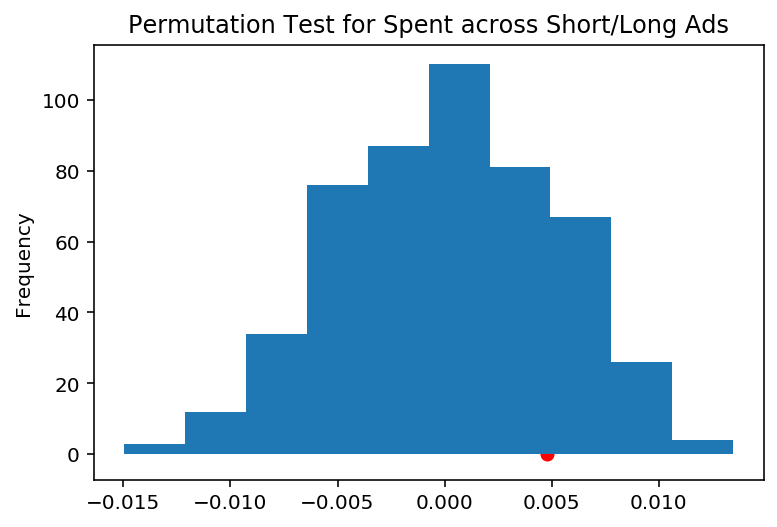

In [14]:
pd.Series(metrs).plot(kind='hist', title='Permutation Test for Spent across Short/Long Ads')
plt.scatter(obs, 0, c='r');